## Test and visualize line segmentation

In [1]:
from tqdm import tqdm

In [2]:
import time, os
import numpy as np
# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
# addons
import torchvision
from torchvision import transforms as trafos
from tensorboardX import SummaryWriter

In [3]:
#%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt

/home/tobias/.virtualenvs/pytorch/local/lib/python2.7/site-packages/matplotlib/__init__.py:907: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)


In [4]:
relative_path = '../../'
# ensure that parent path is on the python path in order to have all packages available
import sys, os
parent_path = os.path.join(os.getcwd(), relative_path)
parent_path = os.path.realpath(parent_path)  # os.path.abspath(...)
sys.path.insert(0, parent_path)

In [5]:
# local stuff
from lib.detection.detection_helpers import visualize_net_output
from lib.utils.transform_utils import UnNormalize
from lib.utils.pytorch_utils import prepare_embedding, visualize_model

from lib.models.linenet import initialize_weights, LRN, LineNetFCN
from lib.models.trained_model_loader import get_line_net_fcn

In [6]:
from lib.datasets.cunei_dataset_segments import CuneiformSegments, get_segment_meta

### Config Basics

In [7]:
model_version = 'v001'

In [8]:
test_collections = ['test']

only_annotated = False
only_assigned = True

In [9]:
data_layer_params = dict(batch_size=[128, 16],
                         img_channels=1,
                         gray_mean=[0.5], # 0.5 #0.488
                         gray_std=[1.0], # 1.0 # 0.231
                         num_classes = 2
                         )

### Config Data Augmentation

In [10]:
num_classes = data_layer_params['num_classes']
num_c = data_layer_params['img_channels']
gray_mean = data_layer_params['gray_mean']
gray_std = data_layer_params['gray_std']

In [11]:
re_transform = torchvision.transforms.Compose([
    UnNormalize(mean=gray_mean, std=gray_std),
    torchvision.transforms.ToPILImage(),
                                              ])

### Load Model

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
model_fcn = get_line_net_fcn(model_version, device, relative_path)

print(model_fcn)

LineNetFCN(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LRN(
      (average): AvgPool2d(kernel_size=1, stride=1, padding=0)
    )
    (4): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): LRN(
      (average): AvgPool2d(kernel_size=1, stride=1, padding=0)
    )
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (13): ReLU(inplace)
    (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1)

/home/tobias/.virtualenvs/pytorch/local/lib/python2.7/site-packages/torch/cuda/__init__.py:117: UserWarning: 
    Found GPU1 GeForce GTX 770 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


### Load Dataset

In [14]:
dataset = CuneiformSegments(collections=test_collections, relative_path=relative_path, 
                            only_annotated=only_annotated, only_assigned=only_assigned, preload_segments=False)

Setup dataset spanning 1 collections with 1610 annotations [16 segments, 16 indices]


In [15]:
seg_im, _, _ = dataset[11]
print(seg_im.size)

(2328, 2973)


### Compute Line Segmenation for Test Set

In [16]:
def preprocess_input(pil_im, scale, shift=None):
    if shift is None:
        shift = 5 # cfg.TEST.SHIFT
    # compute scaled size   
    imw, imh = pil_im.size
    imw = int(imw * scale)
    imh = int(imh * scale)
    # determine crop size
    crop_sz = [int(imw - shift), int(imh - shift)]
    # tensor-space transforms
    ts_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.5], std=[1]), # normalize
    ])
    # compose transforms
    tablet_transform = trafos.Compose([
            trafos.Lambda(lambda x: x.convert('L')), # convert to gray
            trafos.Resize((imh, imw)), # resize according to scale
            trafos.FiveCrop((crop_sz[1], crop_sz[0])), # oversample
            trafos.Lambda(
                lambda crops: torch.stack([ts_transform(crop) for crop in crops])), # returns a 4D tensor
        ])
    # apply transforms
    im_list = tablet_transform(pil_im)
    return im_list

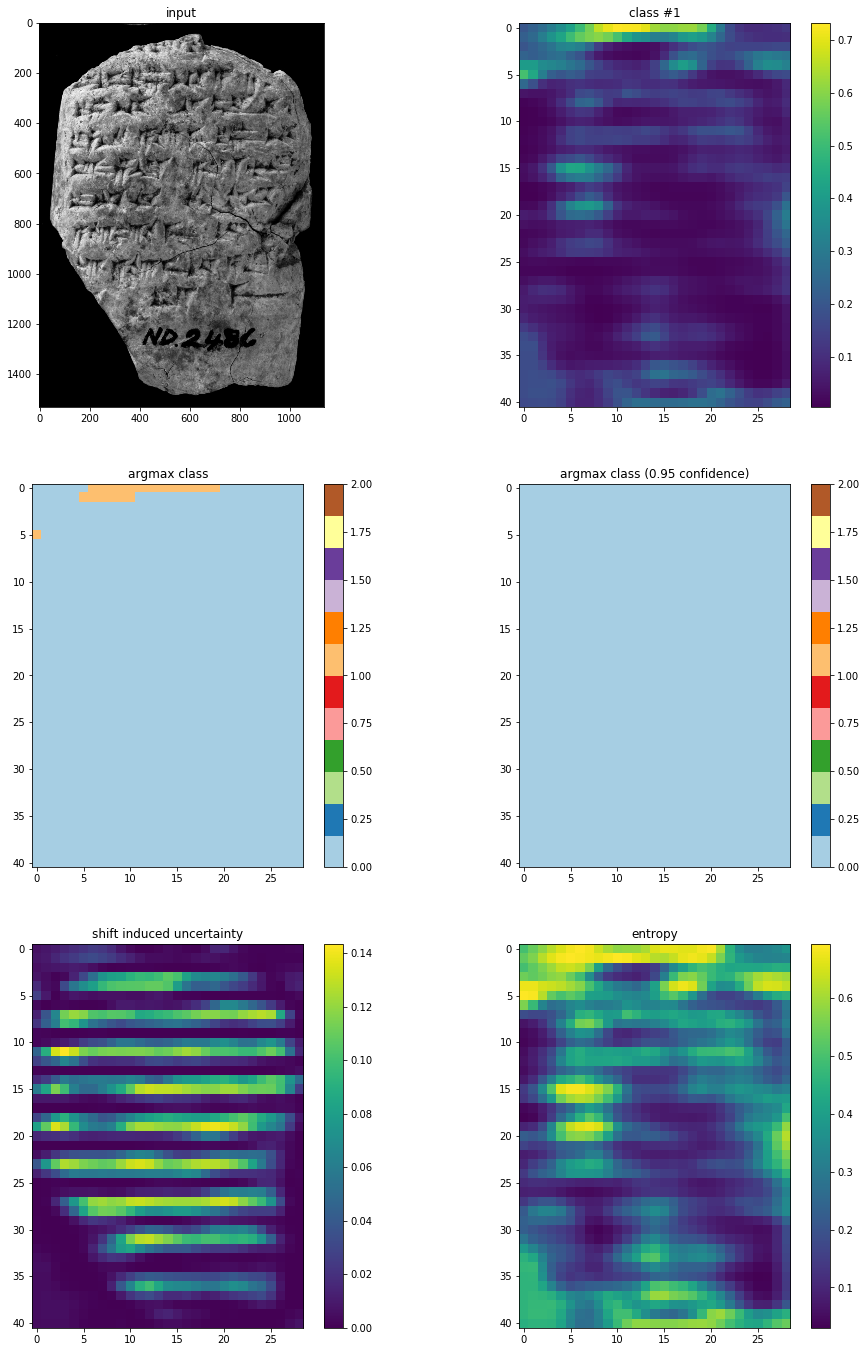

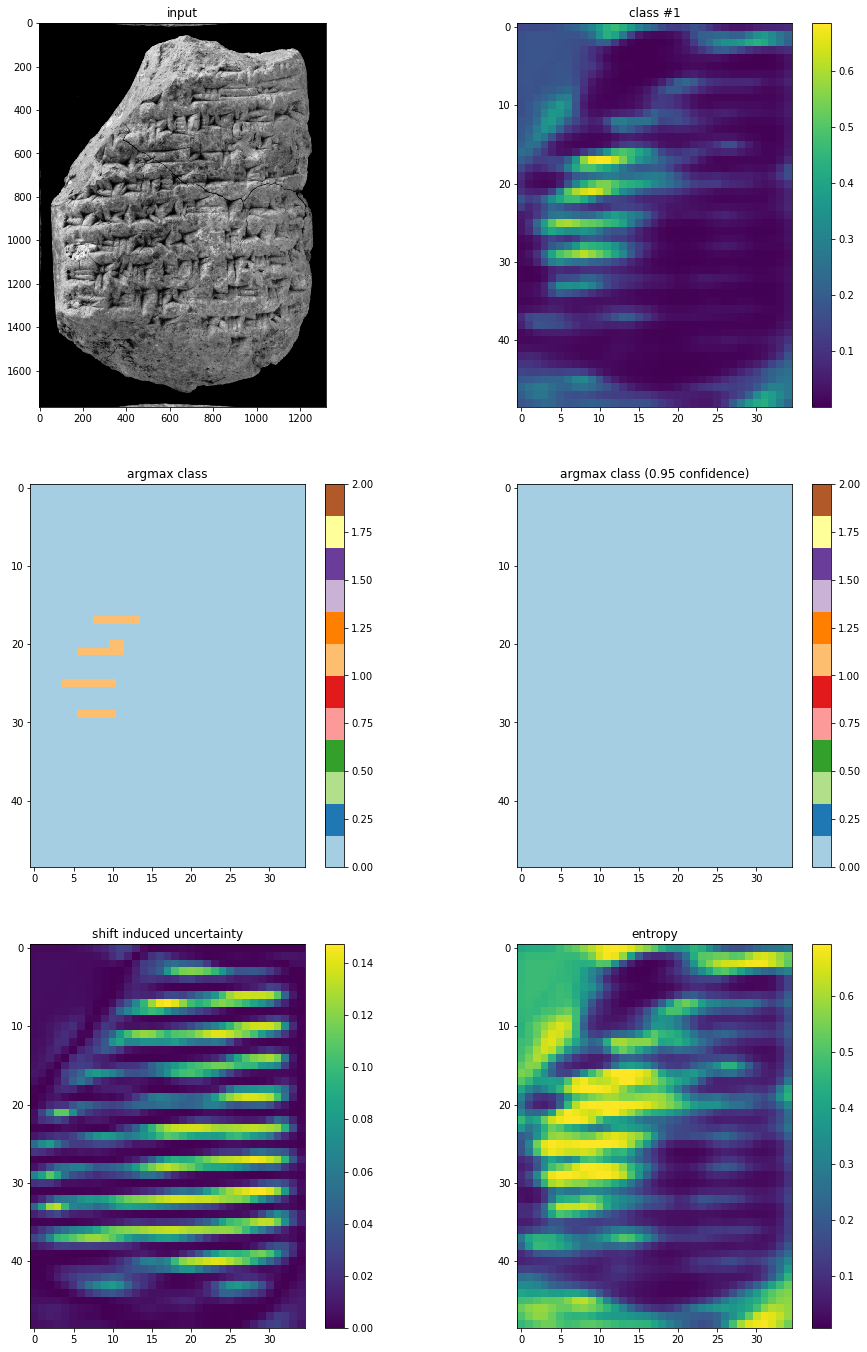

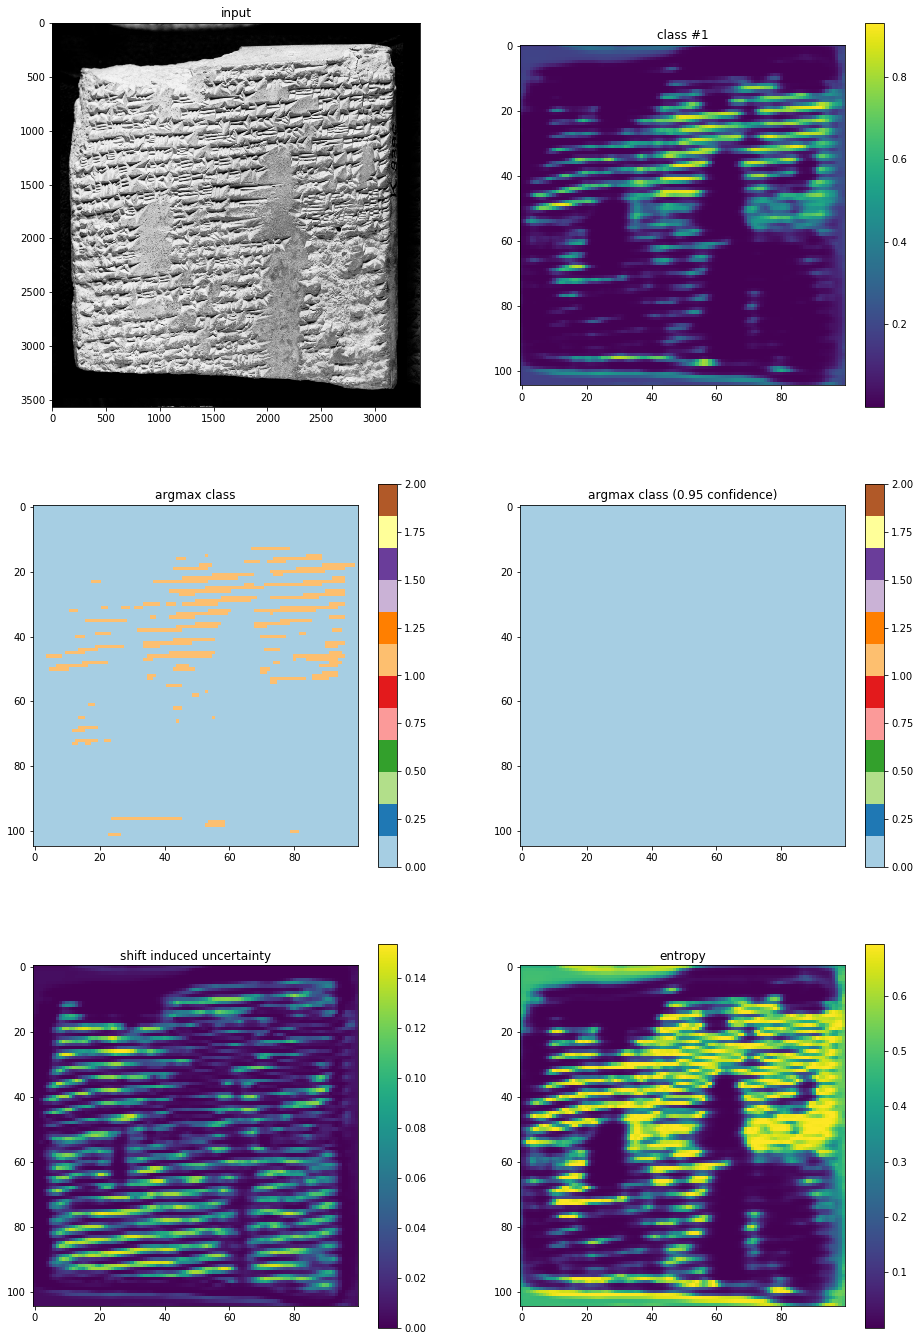

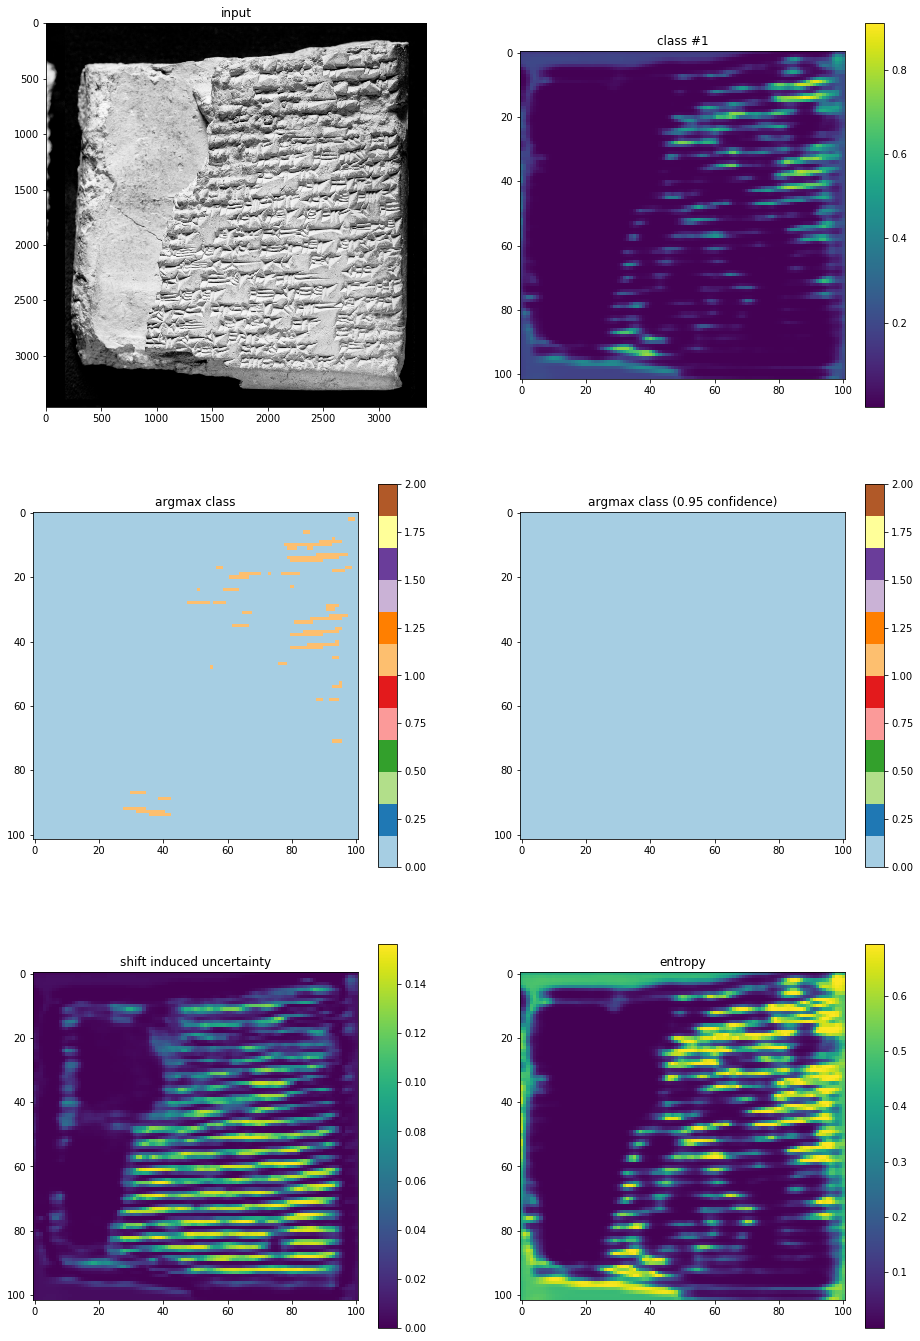

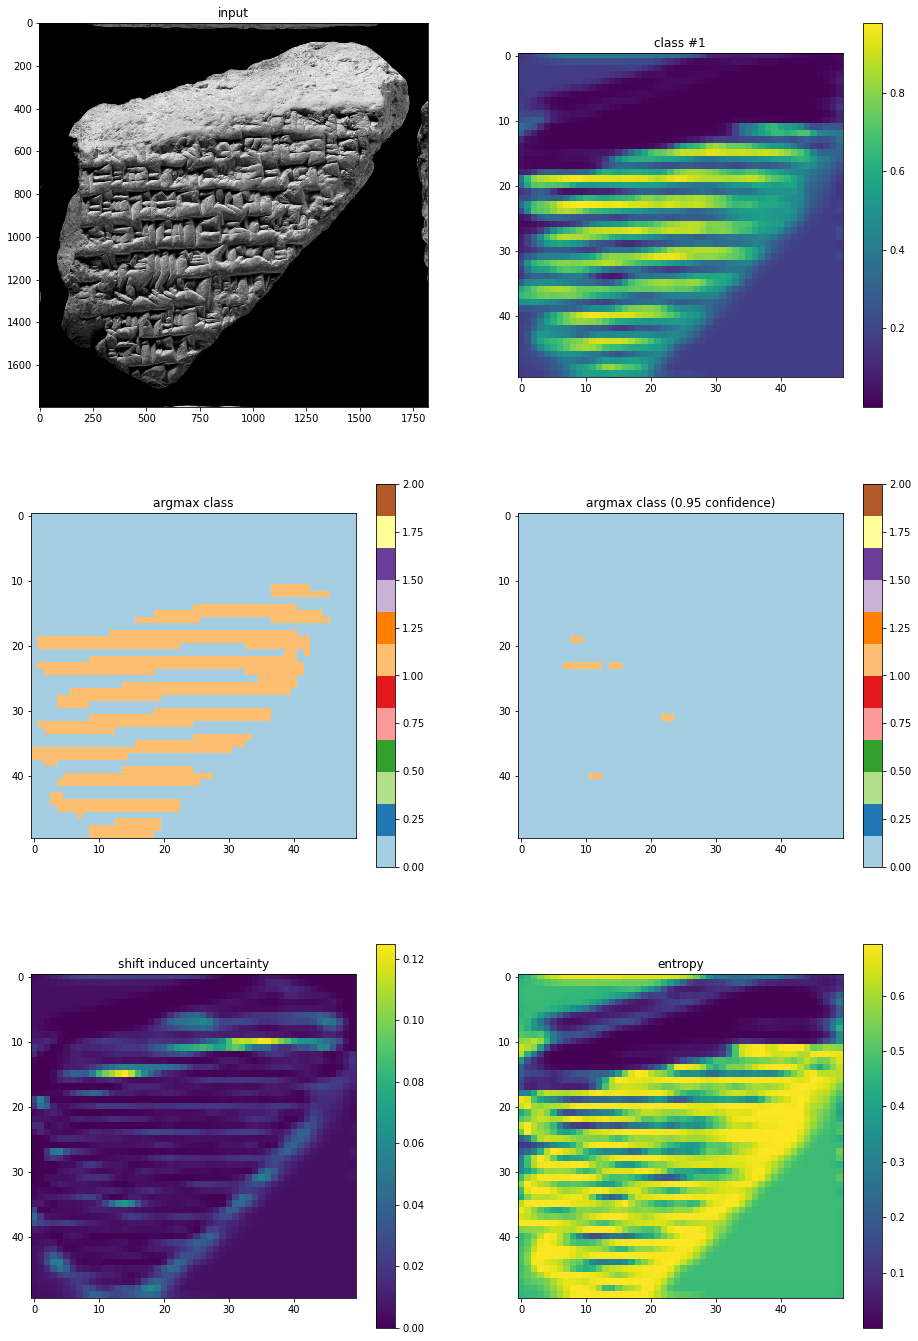

In [17]:
## Custom dataset subset
didx_list = range(len(dataset))
didx_list = didx_list[:5] 

for didx in didx_list:
    seg_im, _, _ = dataset[didx]
    # prepare input
    inputs = preprocess_input(seg_im, 1, shift=None)
    center_im = re_transform(inputs[4]) # to pil image
    center_im = np.asarray(center_im)  # to numpy

    with torch.no_grad(): 
        inputs = inputs.to(device)
        # apply network
        output = model_fcn(inputs)
        # convert to numpy
        output = output.cpu().numpy()

        visualize_net_output(center_im, output, cunei_id=1, num_classes=2)
        plt.show()

### Analyse Output

In [18]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)

In [19]:
output = np.mean(output, axis=0)
lbl_ind = np.argmax(output, axis=0)

# Classic straight-line Hough transform
h, theta, d = hough_line(lbl_ind)

/home/tobias/.virtualenvs/pytorch/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


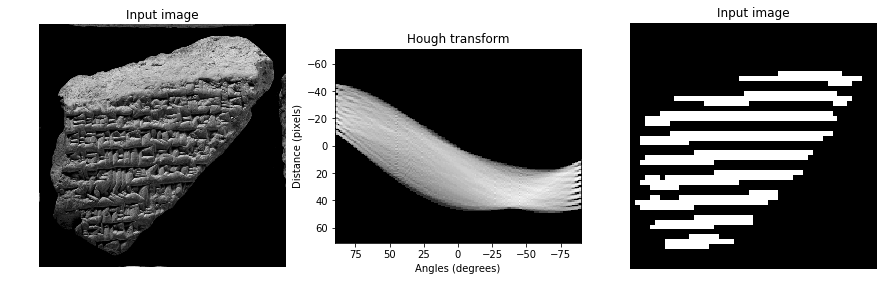

In [20]:
# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6),
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(center_im, cmap='gray')
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap='gray', aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(lbl_ind, cmap='gray')
ax[2].set_title('Input image')
ax[2].set_axis_off()

In [21]:
lines = probabilistic_hough_line(lbl_ind, threshold=10, line_length=10,
                                 line_gap=3)

Text(0.5,1,'Probabilistic Hough')

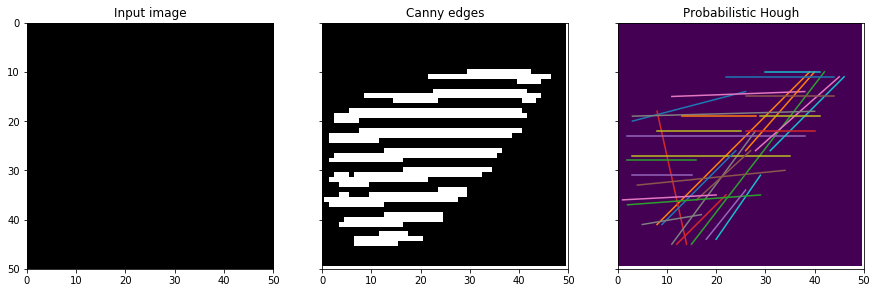

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(center_im, cmap='gray')
ax[0].set_title('Input image')

ax[1].imshow(lbl_ind, cmap='gray')
ax[1].set_title('Canny edges')

ax[2].imshow(lbl_ind * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, lbl_ind.shape[1]))
ax[2].set_ylim((lbl_ind.shape[0], 0))
ax[2].set_title('Probabilistic Hough')